## Instructions

Required Reading: Explore the implementation of [Discrete Markov Chains using NumPy](http://www.scipy-lectures.org/intro/numpy/exercises.html#array-manipulations).

Using the data for [Presidential Elections from 1972-2012](https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state) complete the following tasks:

1. Estimate a two-state discrete Markov chain (with the states being Democrat and Republican).

2. Estimate the steady-state distribution for the chain.

3. Use the 2012 observations by state together with your estimated chain and the [electoral votes for each state](http://state.1keydata.com/state-electoral-votes.php) to predict the 2016 election. Run 100 simulated elections. What is the share of elections won by the Democrat?


Assumptions:

- All US states follow the same chain
- All US states are independent of their neighbors

(Later on we will explore relaxing these assumptions.)



### Notes from class

Markov chain: Given that a place is D/R, what is the probability of becoming D/R? (First-order is what we're using, and only cares about the previous year.)

We are assuming each state has the same transition probabilities, so we're going to be training the system on the full dataset.

PySal has built-in markov chain methods

https://pysal.readthedocs.io/en/latest/library/spatial_dynamics/markov.html

Input a 2D array of data, and it will calculate the transition tables
    markov = pysal.Markov(array)
    markov.transitions
    markov.p # is the probability matrix

Also lets you calculate the long-run steady-state of the system (how many places will be in each state, on average).

## 1. Estimate a two-state discrete Markov chain

With the states being Democrat and Republican.

In [1]:
# Import NumPy and the raw data
from data import R,D, state_history, state_last_vote, state_names, state_electors
import numpy as np

# Build the transition matrix
# Since R=1, D=0, these can be treated as indices
# first dimension is prior state, second dimension is post state
transitions = np.zeros( (2,2) )
for state in state_history:
    for i in range(1,len(state)):
        transitions[state[i-1], state[i]] += 1
print("Transitions:\n",transitions)

rowsum = transitions.sum(axis=1) # Sum by row
print("Sum of each row:\n",rowsum)

# Make probability matrix
P = np.dot(np.diag(1./rowsum),transitions)
print("Probability matrix:\n",P)

# Easier method, since the rows are the first axis:
# P = transitions/rowsum


Transitions:
 [[ 141.   40.]
 [  65.  264.]]
Sum of each row:
 [ 181.  329.]
Probability matrix:
 [[ 0.77900552  0.22099448]
 [ 0.19756839  0.80243161]]


In [2]:
# Functions for getting markov chain and election results

def get_markov_states(p_matrix, current_states):
    """
    Create a set of results based on a set of current states and a probability matrix
    
    Inputs:
    p_matrix: 2x2 matrix
       Row index is initial state, column index is resulting state
    current_states: 1d array
       Values are the current states, must be 1 or 0
       
    Output:
    resulting_state: 1d array
        The final state of each element in current_state, based on the probability matrix
    """
    # Generate a set of random values
    random_values = np.random.rand(len(current_states))
    
    # Create an array that gives true if the state will be 1, false if it will be 0
    is_one = np.array([(r > p_matrix[int(h),0]) for h,r in zip(current_states,random_values)])
    
    # Set the output array values
    result = np.zeros(len(current_states))
    result[is_one] = 1
    
    return result
#

def eval_electoral_college(elector_counts, state_status):
    """
    Tally up electoral votes based on an array of state results
    
    Inputs:
    elector_counts: 1d array
       Contains Electoral College elector counts for each state
    state_status: 1d array
       Contains the vote result for each state, where the value will be the index of the
       output array that this state's elctoral votes will be added to.
       
    Output:
    vote_tally: 1d array
        Votes recieved by each party, where index is the party ID used by state_status
    """
    result = np.zeros(int(max(state_status))+1)
    
    for count, status in zip(elector_counts, state_status):
        result[int(status)] += count
    return result
#

def simulate_elections(p_matrix, initial_state, elector_counts, election_count):
    """
    Run multiple simulated elections, return the win tallies
    
    Inputs:
    p_matrix: 2x2 matrix
        Row index is initial state, column index is resulting state
    current_states: 1d array
        Values are the current states, must be 1 or 0
    elector_counts: 1d array
        Contains Electoral College elector counts for each state
    election_count: integer
        Number of elections to simulate.
       
    Output:
    dem_wins: integer
        Number of wins by the party with index D
    rep_wins: integer
        Number of wins by the party with index R
    ties: integer
        Number of times the two parties tied
    """
    dem_wins = 0
    rep_wins = 0
    ties = 0
    for i in range(election_count):
        # Use a unique seed for each trial run, but keep things repeatable
        # The +100 is just an adjustment to make a tie show up in the results
        #  for a 100-election test
        np.random.seed(i+100)
        
        vote_directions = get_markov_states(p_matrix,initial_state)
        electoral_totals = eval_electoral_college(elector_counts, vote_directions)
        
        if(electoral_totals[R] > electoral_totals[D]):
            rep_wins += 1
        elif(electoral_totals[D] > electoral_totals[R]):
            dem_wins += 1
        else:
            ties += 1
    #
    return dem_wins, rep_wins, ties
#

#############
# QUICK TESTS

#print(simulate_elections(P, [1,1,1], [1,1,1], 1))
#print(eval_electoral_college([1,2,2,3], [0,1,0,0]))


## 2. Estimate the steady-state distribution for the chain.

In [3]:
# Finding steady-state probabilities
P2 = P.dot(P)
for i in range(9):
    print("Chance of being X after %d iterations:"%(i+2))
    print(P2)
    P2 = P2.dot(P2)
#

# Looks like 47% Democrat, 53% Republican

Chance of being X after 2 iterations:
[[ 0.65051113  0.34948887]
 [ 0.31244199  0.68755801]]
Chance of being X after 3 iterations:
[[ 0.53235973  0.46764027]
 [ 0.41806898  0.58193102]]
Chance of being X after 4 iterations:
[[ 0.47891277  0.52108723]
 [ 0.4658504   0.5341496 ]]
Chance of being X after 5 iterations:
[[ 0.47210614  0.52789386]
 [ 0.47193551  0.52806449]]
Chance of being X after 6 iterations:
[[ 0.47201606  0.52798394]
 [ 0.47201603  0.52798397]]
Chance of being X after 7 iterations:
[[ 0.47201605  0.52798395]
 [ 0.47201605  0.52798395]]
Chance of being X after 8 iterations:
[[ 0.47201605  0.52798395]
 [ 0.47201605  0.52798395]]
Chance of being X after 9 iterations:
[[ 0.47201605  0.52798395]
 [ 0.47201605  0.52798395]]
Chance of being X after 10 iterations:
[[ 0.47201605  0.52798395]
 [ 0.47201605  0.52798395]]


In [4]:
# Check the election results using the steady-state probability matrix
# Sure enough, Republicans are more likely to win, because ~53% of states vote Republican
# Interestingly, the win rate is 62%, not 53%, which probably says something about the
#  distribution of electoral vote counts.
dem_wins,rep_wins,ties = simulate_elections(P2, state_last_vote, state_electors, 10000)
print("Democrat wins: %d; Republican wins: %d; Ties: %d"%(dem_wins,rep_wins,ties))

Democrat wins: 3779; Republican wins: 6148; Ties: 73


Populating the interactive namespace from numpy and matplotlib
Republican win count: 58/100 (winning ~0.54% of states)
Republican win count: 59/100 (winning ~0.54% of states)
Republican win count: 59/100 (winning ~0.52% of states)
Republican win count: 66/100 (winning ~0.55% of states)
Republican win count: 68/100 (winning ~0.54% of states)
Above the black line is Republican win, below the black line is Democrat win:


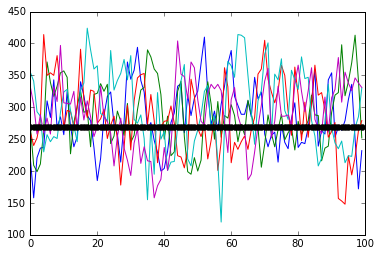

In [5]:
# The same results (roughly) are found when running a few chains out to 100 iterations
# Republicans win ~53% of states, and ~60% of elections

# List of election chain results
# Each element will be a list of the avlue in each cycle 
r_results = [] # Republican electoral vote count
r_state_counts = [] # Count of states won by Republicans

chain_length = 100

state_status = state_last_vote
for i in range(5):
    np.random.seed(i)
    r_list = []
    r_count_list = []
    # Run things out for chain_length election cycles
    for i in range(chain_length):
        state_status = get_markov_states(P,state_status)
        electoral_totals = eval_electoral_college(state_electors, state_status)
        
        r_list.append(electoral_totals[R])
        r_count_list.append(sum(state_status)/50)
    r_results.append(r_list)
    r_state_counts.append(r_count_list)
#
%pylab inline

for x,count in zip(r_results,r_state_counts):
    plot(x,'-')
    print("Republican win count: %d/%d (winning ~%.2f%% of states)"%(sum([1 for result in x if result > 269]),len(x),sum(count)/chain_length))
plot(np.ones(chain_length)*269,'ko')

print("Above the black line is Republican win, below the black line is Democrat win:")


## 3. Use the 2012 observations by state together with your estimated chain and the [electoral votes for each state](http://state.1keydata.com/state-electoral-votes.php) to predict the 2016 election.

Run 100 simulated elections. What is the share of elections won by the Democrat?

In [6]:
dem_wins,rep_wins,ties = simulate_elections(P, state_last_vote, state_electors, 100)
print("Democrat wins: %d; Republican wins: %d; Ties: %d"%(dem_wins,rep_wins,ties))

# 80% chance of a Democrat win.  A bit higher than 538's current estimates, but within the bounds of other estimates.
# Far below 538's estimates of generic Democrat vs. generic Republican from early in the race, though.

Democrat wins: 79; Republican wins: 20; Ties: 1
